In [1]:
#import libraries
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import random
import time

In [2]:
#read data to a dataframe and convert that to a numpy array which we shuffle
df = pd.read_csv('multigauss.txt', delim_whitespace=True, skiprows=(0,1,2,3), names=['Xpos','Ypos'])
print(df)
Data = df.to_numpy()
Data = shuffle(Data, random_state=88)

          Xpos      Ypos
0     1.343973  0.151104
1     0.962672  0.382781
2     0.502326 -0.181393
3     0.367746  0.804005
4    -0.807914  0.269209
...        ...       ...
1245 -1.394011  4.202079
1246 -3.643562  5.600143
1247 -3.995956  3.211125
1248 -3.005766  1.720398
1249 -3.290476  0.737522

[1250 rows x 2 columns]


In [3]:
#exactly the same as my K-means code from question 4 only now it doesn't print and exits after the second iteration
def euclideanDist(pointA, pointB):
    d = 0.0
    for index in range(len(pointA)):
        d += (float(pointA[index])-float(pointB[index]))**2
    d = np.sqrt(d)
    return d
def mean(clustr):
    if len(clustr) == 0:
        return None
    if len(clustr) == 1:
        return clustr[0]
    sumattr = list(clustr[0])
    for i in clustr[1:]:
        l = 0
        for j in i:
            sumattr[l] += j
            l += 1
    return [ele/len(clustr) for ele in sumattr]
def checker(listA, listB):
    for i in range(len(listA)):
        if (listA[i] != listB[i]):
            return False
    return True
def kmeans(k,data,centers,itter):
    #print('iteration %d'%itter)
    clusters = []
    for count in range(k):
        clusters.append([])
    newcenters = []
    for datapoint in data:
        dist = []
        for center in centers:
            dist.append(euclideanDist(datapoint,center))
        index = 0
        for distance in dist:
            if distance == min(dist):
                clusters[index].append(datapoint)
                break
            index += 1
    for cluster in clusters:
        newcenters.append(mean(cluster))
    for a,b in zip(newcenters,centers):
        if itter > 1:
            break
        if not checker(a,b):
            return kmeans(k,data,newcenters,itter+1)
    return (newcenters,clusters)

In [4]:
# n represents the size of our dataset
n = len(Data)
# f represents the number of features
f = 2
# k represents the number of gaussians
k = 5

# here the clusters(gaussians) and centers are calculated using kmeans
random.seed(11)
s = random.sample(list(Data), k)
tup = kmeans(k,Data,s,1)
gaussians = [np.array(c) for c in tup[1]]

# w is an n by k matrix of membership weights. w[i][j] is the probability that Data[i] was generated by gaussians[j]
w = np.zeros((n,k))

# mixtures is a k by 1 vector of mixture weights (gaussian prior probabilities).
# mixtures[i] is the prior probability that any point belongs to cluster i and is initialized as such
mixtures = np.zeros((len(gaussians),1))
for i in range(k):
    mixtures[i][0]=len(gaussians[i])/n

# means is a k by f matrix containing the means of each gaussian
# initialized by the means of the gaussians from kmeans
means = np.zeros((k,f))
for i in range(k):
    for j in range(f):
        means[i][j] = sum(gaussians[i].T[j])/len(gaussians[i])

# covariances is a j by j by k tensor of covariance matrices.
# covariances[:,:,i] is the covariance of gaussian i
# initialized by the covariances of the gaussians from kmeans
covariances = np.zeros((f,f,k))
for i in range(k):
    covariances[:,:,i] = np.cov(gaussians[i].T)

E-step
$$
\\ \gamma_k(x) = p(z_k=1|x)=\frac{\pi_k\mathcal{N}(x|\mu_k,\Sigma_k)}{\sum_j\pi_j\mathcal{N}(x|\mu_j,\Sigma_j)}
$$

In [5]:
# This function takes in a set of parameters of a gaussian mixture model, 
# and outputs the membership weights of each data point
def Expectation(X,k,Pi,Mu,Sigma):
    # this whole function is an application of bayes thm
    weights = np.zeros((len(X),k))
    # weights is the posterior probabilites
    denominator = 0.0
    # denominator is the predictor prior probability for X[i]
    for i in range(len(X)):
        denominator = 0.0
        for c in range(k):
            denominator += Pi[c][0] * (1/np.sqrt(((2*np.pi)**2)*np.linalg.det(Sigma[:,:,c]))) *\
            np.exp(-0.5*np.dot(np.dot((X[i]-Mu[c]).T,np.linalg.inv(Sigma[:,:,c])),(X[i]-Mu[c])))
        for j in range(k):
            # Pi[j] is our mixtures, so it represents the class prior probability for gaussian[j]
            # Sigma = covariance, Mu = mean, X[i] = the i'th datapoint
            # the gaussian distribution represents the class conditional probability
            weights[i,j] = Pi[j][0] * (1/np.sqrt(((2*np.pi)**2)*np.linalg.det(Sigma[:,:,j]))) *\
            np.exp(-0.5*np.dot(np.dot((X[i]-Mu[j]).T,np.linalg.inv(Sigma[:,:,j])),(X[i]-Mu[j]))) /\
            denominator
    return weights

M-step
$\\ 1 \text{ re-estimate params}$
$$
\\ \mu_k = \frac{1}{N_k}\sum^N_{n=1}\gamma(z_{nk})x_n
\\ \Sigma_k = \frac{1}{N_k}\sum^N_{n=1}\gamma(z_{nk})(x_n-\mu_k)(x_n-\mu_k)^\top
\\ \pi_k = \frac {N_k} N
$$
$\\ 2 \text{ evaluate log likelihood}$
$$
\\ \ln p(X|\pi,\mu,\Sigma) = \sum^N_{n=1}\ln \{\sum^K_{k=1} \pi_k\mathcal{N}(x_n|\mu_k,\Sigma_k )\}
$$

In [6]:
# This function takes in the training data along with the membership weights, 
# and calculates the new maximum likelihood mean for each gaussian.
def MaximizeMean(X,k,w):
    # X represents our dataset, k is the number of gaussians, and w is the membership weights
    mew = np.zeros((k,len(X[0])))
    #mew[i] represents the mean of gaussian i
    for c in range(k):
        for n in range(len(X)):
            mew[c,:] += w[n][c]*X[n]
        mew[c,:] *= (1/sum(w[:,c]))
    return mew

In [7]:
# This function takes in the training data along with membership weights and means for each gaussian,
# and calculates the new maximum likelihood covariance for each gaussian
def MaximizeCovariance(X,k,w,Mu):
    # X represents our dataset, k is the number of gaussians, and w is the membership weights, Mu is the gaussian means
    sigma = np.zeros((len(X[0]),len(X[0]),k))
    # sigma represents the covariance of the gaussians
    for j in range(k):
        for i in range(len(X)):
            sigma[:,:,j] += w[i,j]*np.outer((X[i]-Mu[j]),(X[i]-Mu[j]))
        sigma[:,:,j] *= (1/sum(w[:,j]))
    return sigma

In [8]:
# This function takes in the membership weights, 
# and calculates the new maximum likelihood mixture weight for each gaussian.
def MaximizeMixtures(k,w):
    # w represents the membership weights and k the number of gaussians
    pi = np.zeros((k,1))
    # pi represents the gaussian prior probabilites
    for i in range(k):
        pi[i][0]=sum(w[:,i])/len(w[:,i])
    return pi

In [9]:
# This function takes in the training data along with the membership weights, 
# and calculates the new maximum likelihood mean for each gaussian.
def LogLikelihood(X,k,Pi,Mu,Sigma):
    # Params defined as in above functions
    retval = 0.0
    # retval is our final return value, it is the sum of the natural log of all values for s
    s = 0.0
    # s is a temporary variable representing the sum of values calculated in the inner loop
    for i in range(len(X)):
        s = 0.0
        for j in range(k):
            s += Pi[j][0] * (1/np.sqrt(((2*np.pi)**2)*np.linalg.det(Sigma[:,:,j]))) *\
            np.exp(-0.5*np.dot(np.dot((X[i]-Mu[j]).T,np.linalg.inv(Sigma[:,:,j])),(X[i]-Mu[j])))
        retval += np.log(s)
    return retval

In [10]:
# This function runs the EM algorithm for nIter steps and returns the parameters of the underlying GMM.
def EM(X,k,Pi,Mu,Sigma,nIter):
    track=[LogLikelihood(X,k,Pi,Mu,Sigma)]
    for epoch in range(1, nIter+1):
        # E-Step
        # update the weights
        weights = Expectation(X,k,Pi,Mu,Sigma)
        # M-Step
        # re-establish responcibilities given new weight
        Mu = MaximizeMean(X,k,weights)
        Sigma = MaximizeCovariance(X,k,weights,Mu)
        Pi = MaximizeMixtures(k,weights)
        # get the new Log-Likelihood
        track.append(LogLikelihood(X,k,Pi,Mu,Sigma))
        # implement stop checking for overfitting
        if(len(track)>1 and track[epoch]<track[epoch-1]):
            return (track,weights,Mu)
    return (track,weights,Mu)

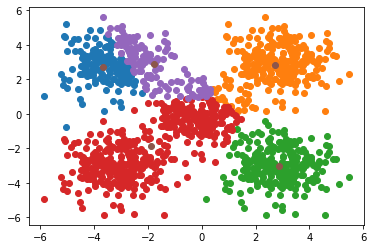

[[-3.6745  2.714 ]
 [ 2.7388  2.8145]
 [ 2.8608 -2.9991]
 [-1.8881 -1.8736]
 [-1.7831  2.8797]]


In [11]:
#displays our initial clusters before EM is applied
for gaussian in gaussians:
    plt.scatter(gaussian.T[0],gaussian.T[1])
#displays our initial cluster centers before EM is applied
plt.scatter(np.array(tup[0]).T[0],np.array(tup[0]).T[1])
plt.show()
print(means)

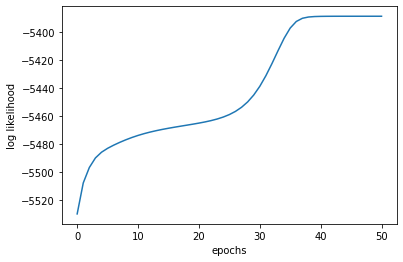

In [12]:
# calls the expectation maximization functions using our initial params,
# and plots the changes in the log likelihood over 50 iterations
fin = EM(Data,k,mixtures,means,covariances,50)
plt.xlabel('epochs')
plt.ylabel('log likelihood')
plt.plot(fin[0])
plt.show()

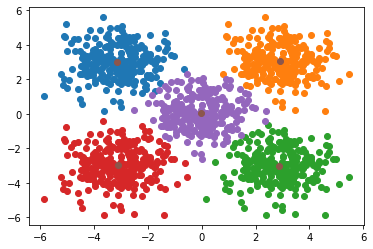

In [13]:
#defines and initializes newG as a list of lists containing the datapoints in our new gaussians updated by the EM algo
newG = []
for i in range(k):
    newG.append([])
for n in range(len(fin[1])):
    for m in range(k):
        if max(fin[1][n]) == fin[1][n][m]:
            newG[m].append(Data[n])
#displays our improved clusters after EM is applied
for G in newG:
    plt.scatter([xpos[0] for xpos in G],[ypos[1] for ypos in G])
#displays our improved cluster centers after EM is applied
plt.scatter(fin[2].T[0],fin[2].T[1])
plt.show()